In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from itertools import product
import warnings 
from warnings import filterwarnings
filterwarnings('ignore')
plt.style.use('seaborn')

In [2]:
# Define the parameters for FinancialInstrument object
ticker='btc-usd'
start='2019-01-01'
end=pd.to_datetime('today')

In [3]:
# Download historical price data from Yahoo Finance for the specified ticker and date range
data=yf.download(ticker,start,end)
data=data[['Close']]
data.rename(columns={'Close':'price'},inplace=True)
data

[*********************100%***********************]  1 of 1 completed


,price
Date,
2019-01-01,3843.520020
2019-01-02,3943.409424
2019-01-03,3836.741211
2019-01-04,3857.717529
2019-01-05,3845.194580
...,...
2023-11-22,37432.339844
2023-11-23,37289.621094
2023-11-24,37720.281250


In [4]:

class FinancialInstrument():
    # Constructor to initialize the FinancialInstrument object
    def __init__(self, ticker, start, end):
        # Assign provided values to object attributes
        self.ticker = ticker
        self.start = start
        self.end = end
        # Call the get_data and log_returns methods to fetch data and calculate log returns
        self.get_data()
        self.log_returns()

    # Representation method for a concise string representation of the object
    def __repr__(self):
        return 'FinancialInstrument(ticker={}, start={}, end={})'.format(self.ticker, self.start, self.end)

    # Method to fetch historical price data using Yahoo Finance API
    def get_data(self):
        # Download historical data for the specified ticker and time period
        raw = yf.download(self.ticker, self.start, self.end)
        # Extract and rename the 'Close' column to 'price'
        raw = raw[['Close']]
        raw.rename(columns={'Close': 'price'}, inplace=True)
        # Assign the processed data to the object attribute 'data'
        self.data = raw

    # Method to plot the historical price of the financial instrument
    def price_plot(self):
        # Plot the 'price' column of the data
        self.data.price.plot(figsize=(12, 6))
        # Set the plot title
        plt.title('Price Chart For {}'.format(self.ticker))

    # Method to calculate and store log returns in the 'returns' column of the data
    def log_returns(self):
        self.data['returns'] = np.log(self.data.price / self.data.price.shift(1))

    # Method to plot the histogram of log returns
    def plot_returns(self):
        # Plot a histogram of the 'returns' column with 100 bins
        self.data.returns.plot(kind='hist', bins=100, figsize=(12, 6))
        # Set the plot title
        plt.title('Returns for {}'.format(self.ticker))


In [5]:
# Create an instance of the FinancialInstrument class
fi=FinancialInstrument(ticker,start,end)

[*********************100%***********************]  1 of 1 completed


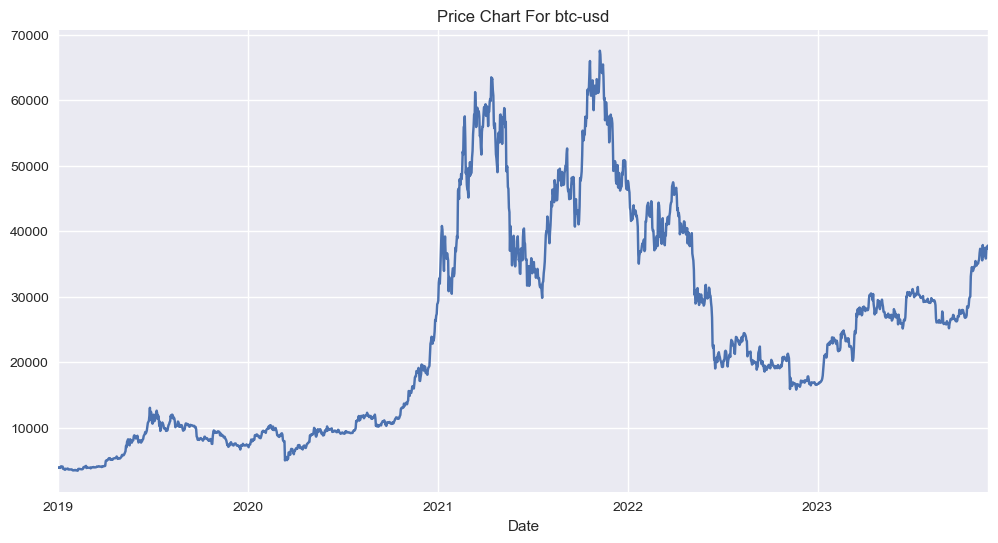

In [6]:
# Plot the historical prices of the financial instrument
fi.price_plot()

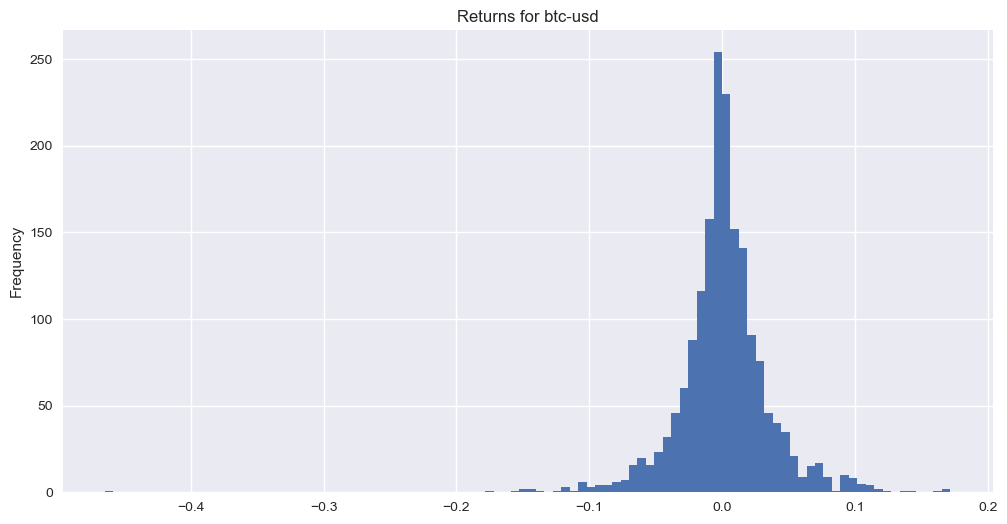

In [7]:
# Plot a histogram of the log returns of the financial instrument
fi.plot_returns()

In [9]:
# Define the function for testing a trading strategy based on SMA
def test_strategy(SMA):
    # Copy the data to avoid modifying the original DataFrame
    df = data.copy()
    # Calculate log returns
    df['returns'] = np.log(df['price'] / df['price'].shift(1))
    # Calculate rolling averages for short and long SMAs
    df['sma_s'] = df['price'].rolling(int(SMA[0])).mean()
    df['sma_l'] = df['price'].rolling(int(SMA[1])).mean()
    # Drop rows with NaN values
    df.dropna(inplace=True)

    # Generate trading signals based on SMAs
    df['position'] = np.where(df['sma_s'] > df['sma_l'], 1, -1)
    # Calculate strategy returns
    df['strategy'] = df['position'].shift(1) * df['returns']
    df.dropna(inplace=True)

    # Calculate the cumulative returns of the strategy and sum them up
    return np.exp(df['strategy']).sum()

# Define ranges for short and long SMAs
sma_s_range = range(10, 50, 1)
sma_l_range = range(50, 250, 1)
# Generate combinations of SMA parameters
combinations = list(product(sma_s_range, sma_l_range))

# Ensure that results and combinations have the same length
results = [test_strategy(comb) for comb in combinations]

# Create a DataFrame to store SMA combinations and their corresponding performance
many_result = pd.DataFrame(data=combinations, columns=['sma_s', 'sma_l'])
many_result['performance'] = results

# Print or analyze the top 10 results based on performance

many_result.nlargest(10, 'performance')


,sma_s,sma_l,performance
3600,28,50,1745.635937
4000,30,50,1745.472871
3800,29,50,1745.393698
0,10,50,1745.305397
3400,27,50,1745.301504
3200,26,50,1745.248865
200,11,50,1745.168109
2800,24,50,1745.072262
400,12,50,1745.004629
3000,25,50,1744.988734


In [10]:
# Define the SMA class
class SMA():
    
    def __init__(self, ticker, sma_s, sma_l, start, end):
        # Initialize instance variables
        self.ticker = ticker
        self.start = start
        self.end = end
        self.sma_s = sma_s
        self.sma_l = sma_l
        self.df = None
        # Fetch data and test the strategy on initialization
        self.get_data()
        self.test_strategy()
        
    def get_data(self):
        # Download historical price data from Yahoo Finance
        raw = yf.download(self.ticker, self.start, self.end)
        raw = raw[['Close']].copy()
        raw.rename(columns={'Close': 'price'}, inplace=True)
        # Calculate short and long simple moving averages
        raw['sma_s'] = raw.price.rolling(self.sma_s).mean()
        raw['sma_l'] = raw.price.rolling(self.sma_l).mean()
        # Calculate log returns
        raw['returns'] = np.log(raw.price / raw.price.shift(1))
        # Drop rows with NaN values
        raw.dropna(inplace=True)
        self.df = raw
        
    def get_results(self):
        # Return the DataFrame with calculated indicators
        return self.df 

    def plot_results(self):
        # Plot historical prices and SMAs
        self.df[['price', 'sma_s', 'sma_l']].plot(figsize=(12, 6))
        plt.title('Price chart for {} with sma {}|{}'.format(self.ticker, self.sma_s, self.sma_l), fontweight='bold')
    
    def test_strategy(self):
        # Generate trading signals based on SMAs
        self.df['position'] = np.where(self.df['sma_s'] > self.df['sma_l'], 1, -1)
        # Calculate strategy returns
        self.df['strategy'] = self.df['position'].shift(1) * self.df['returns']
        # Calculate cumulative returns for both strategy and benchmark
        self.df['creturns'] = self.df['returns'].cumsum().apply(np.exp)
        self.df['cstrategy'] = self.df['strategy'].cumsum().apply(np.exp)
        # Drop rows with NaN values
        self.df.dropna(inplace=True)
        return self.df
    
    def plot_strategy(self):
        # Plot SMA indicators and trading positions
        self.df.loc['2023':, ['sma_s', 'sma_l', 'position']].plot(secondary_y='position')
        plt.title('{} {}|{} position'.format(self.ticker, self.sma_s, self.sma_l), fontweight='bold')
        
    def total_returns(self):
        # Calculate total returns and outperformance
        perf = self.df['cstrategy'].iloc[-1]
        outperf = perf - self.df['creturns'].iloc[-1]
        return round(perf, 3), '|', round(self.df['creturns'].iloc[-1], 3), '|', round(outperf, 3) 
     
    def plot_total_returns(self):
        # Plot cumulative returns for strategy and benchmark
        self.df[['creturns', 'cstrategy']].plot(figsize=(12, 6))
        plt.title('Return chart for {} with SMA {}|{} strategy'.format(self.ticker, self.sma_s, self.sma_l), fontweight='bold')


In [11]:
# Initialize an instance of the SMA class with specified parameters
strategy=SMA(ticker,28,50,start,end)

[*********************100%***********************]  1 of 1 completed


In [12]:
# Retrieve the DataFrame with calculated indicators from the SMA instance
strategy.get_results()

,price,sma_s,sma_l,returns,position,strategy,creturns,cstrategy
Date,,,,,,,,
2019-02-20,3999.820557,3600.982736,3669.652021,0.013270,-1,-0.013270,1.021479,0.986818
2019-02-21,3954.118164,3613.598903,3669.866196,-0.011492,-1,0.011492,1.009808,0.998224
2019-02-22,4005.526611,3628.090358,3673.241904,0.012917,-1,-0.012917,1.022936,0.985412
2019-02-23,4142.526855,3647.378444,3678.938091,0.033631,-1,-0.033631,1.057924,0.952823
2019-02-24,3810.427490,3655.466361,3678.242749,-0.083565,-1,0.083565,0.973112,1.035867
...,...,...,...,...,...,...,...,...
2023-11-22,37432.339844,35814.545898,32728.617461,0.044201,1,0.044201,9.559517,32.944704
2023-11-23,37289.621094,35926.437779,32918.421992,-0.003820,1,-0.003820,9.523070,32.819095
2023-11-24,37720.281250,36062.526367,33124.509375,0.011483,1,0.011483,9.633052,33.198125


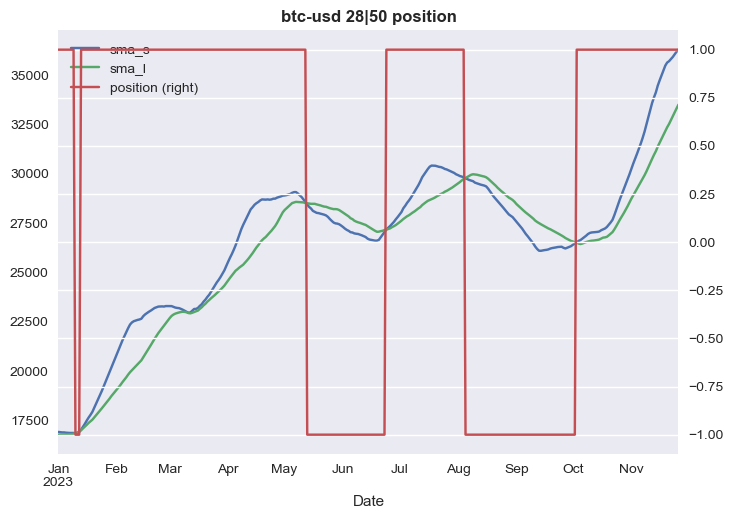

In [13]:
# Plot SMA indicators and trading positions for 2023
strategy.plot_strategy()

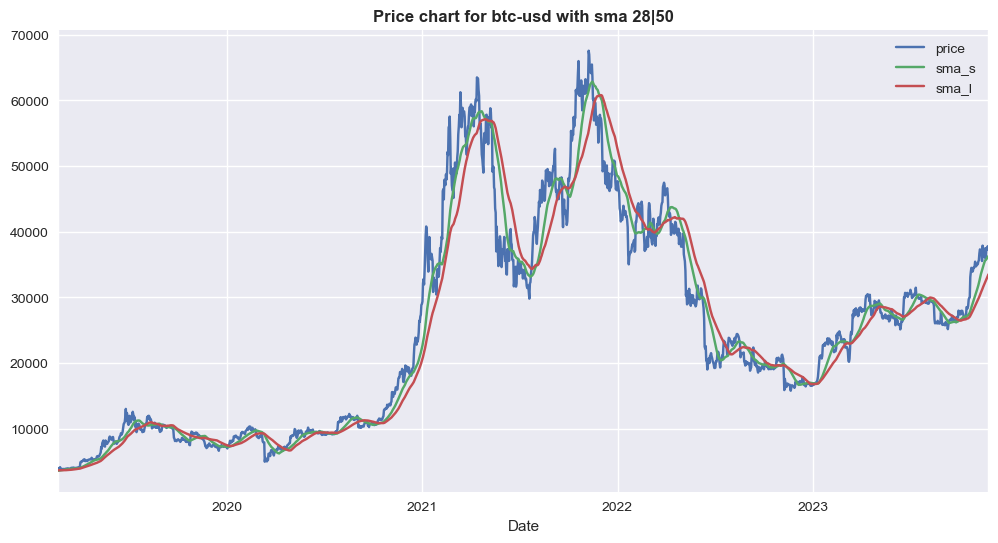

In [14]:
# Plot historical prices and SMAs
strategy.plot_results()

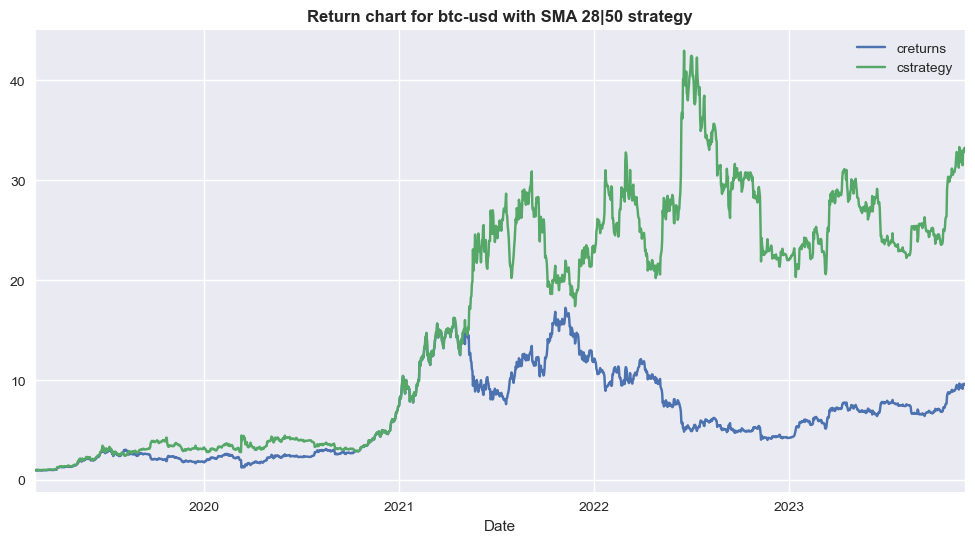

In [15]:
# Plot cumulative returns for strategy and benchmark
strategy.plot_total_returns()